# Projet spam filter by Steve and Jeremy

![title](SPAM-1.png)
                                      Projet en collaboration avec le gretta

## ANALYSE DES DONNEES

### Analyse du DF 

In [1311]:
#importation des librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

La première étape: Ouvrir le fichier csv et visualiser son contenu. 

In [1312]:
#ouverture du fichier csv

df = pd.read_csv('spam.csv',encoding= 'latin-1')

In [1313]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Nous remarquons qu'il y a des colonnes qui sont inules et que les noms des colonnes ne sont pas parlants


In [1314]:
df.nunique(axis=0)# returns the number of unique values for each variable.

v1               2
v2            5169
Unnamed: 2      43
Unnamed: 3      10
Unnamed: 4       5
dtype: int64

### Nettoyage du DF 

In [1315]:
#NETTOYAGE DES DONNEES
dfn = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
dfn = dfn.rename(columns={'v1':'label', 'v2':'sms'})
dfn

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Nous enlevons les colonnes inutiles et renommons les colonnes importantes

## VISUALISATION DES DONNEES

Dans cette partie nous allons visualisé notre jeu de donnée.

In [1316]:
dfn.describe()

,label,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Nous voyons qu'il y a 5572 sms 

### Proportion des spam/ham 

In [1317]:
#compter le nombre de spam/ham
dfn.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

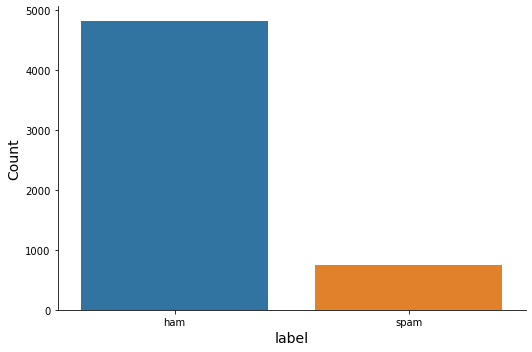

In [1318]:
#compter spam et ham
import matplotlib.pyplot as plt
sns.catplot( x='label',
             kind="count", 
             data=dfn,
             height=5,
             aspect=1.5)
plt.xlabel("label", size=14)
plt.ylabel("Count", size=14)
plt.tight_layout()
plt.savefig("Countplot_or_barplot_with_Seaborn_catplot.png")


Nous remarquons que notre jeu de donnée est déséquilibré. La proportion de ham est bien plus élevé que les spams, cela sera à prendre en compte lors de la partie étude du model de ML. 

## RECHERCHE DES FEATURES

Maintenant que nous connaissons bien notre jeu de donnée nous allons devoir créer des features qui seront utiliser
par notre model de ML. Les features vont permettre d'analyser les sms et leurs donner des caractérisques. 
Pour notre jeu de donnée nous avons décidé d'utiliser 7 features:

    -Taille du message
    -Dictionnaire de mots
    -Les urls
    -Les numéros de téléphone
    -Les majuscules et minuscules
    -Les caractères spéciaux
    -La longueur moyenne des mots

### Feature1: Taille du message.

Dans la première partie nous allons déterminer la longueur moyenne des sms

In [1319]:
#compter la longueur des s
dfn['length'] = dfn['sms'].apply(len)
dfn.head()

,label,sms,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


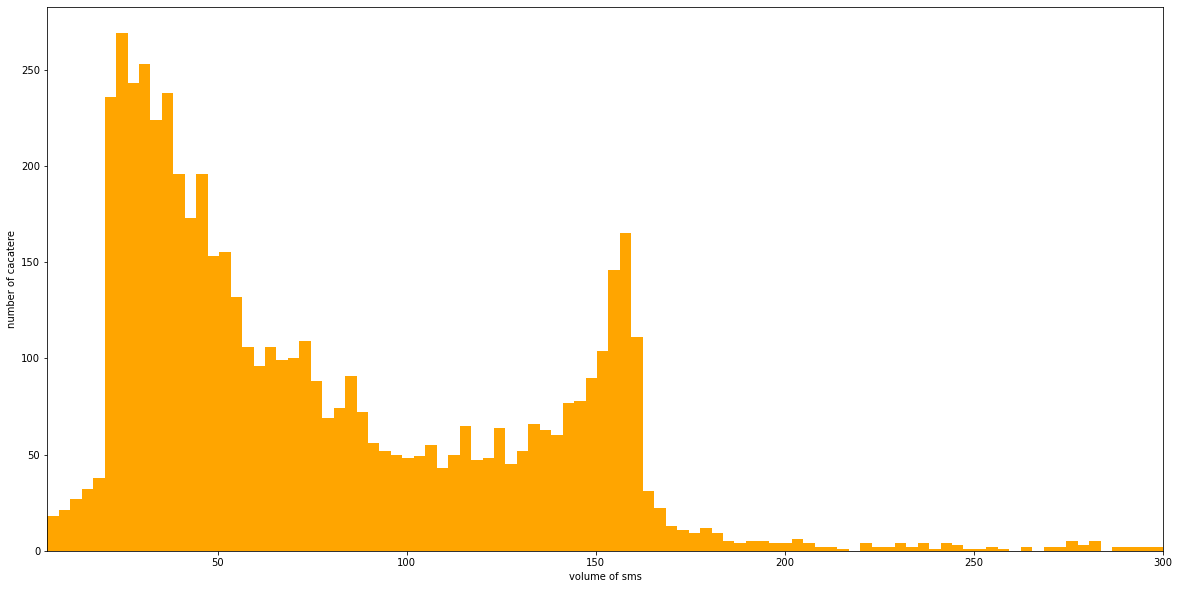

In [1320]:
#length of sms visualisaion with histogram
dfn['length'].plot(bins=300, kind='hist', color='orange')
plt.ylabel('number of cacatere')
plt.xlabel('volume of sms')
plt.xlim(5,300)
plt.show()

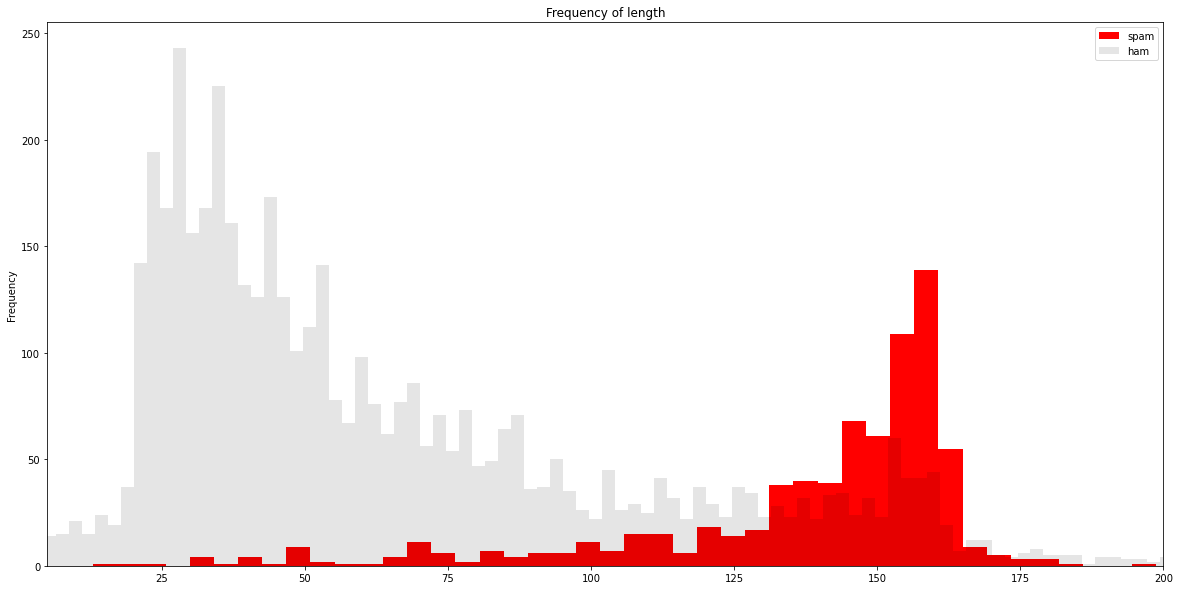

In [1321]:
#Histrogram par SPAM OU HAM
x1 = dfn['length'].loc[dfn.label=='spam']
x2 = dfn['length'].loc[dfn.label=='ham']
kwargs = dict(alpha=1, bins=50)
kwargs2 = dict(alpha=0.1, bins=400)

plt.hist(x1, **kwargs, color='r', label='spam')
plt.hist(x2, **kwargs2, color='black', label='ham')

plt.gca().set(title='Frequency of length', ylabel='Frequency')
plt.xlim(5,200)
plt.legend();

Nous remarquons très clairement que les spams sont bien plus longs que les hams. Cela confirme l'importance de cette features dans notre DataFrame. 

In [1322]:
#compter la longueur des s
dfn['length'] = dfn['sms'].apply(len)
dfn.head()

,label,sms,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Feature2:Dictionnaire de mots

Dans cette seconde partie nous allons créer un dictionnaire des mots les plus communs dans un spam et nous allons les compter dans tous les messages. Pour cela nous utisons la librairie Wordcloud qui nous permet de sortir graphiquement tous les mots les plus utilisés. Nous allons faire une analyse séparé sur les spams et hams, cela nous permettra de trouver les stopword. Les stopwords permettent d'avoir un dictionnaire de mot plus cohérent.

In [1323]:
import collections
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import webbrowser

#### Visualisation des mots dans les hams

In [1324]:
#lien du tuto
#webbrowser.open('https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb')

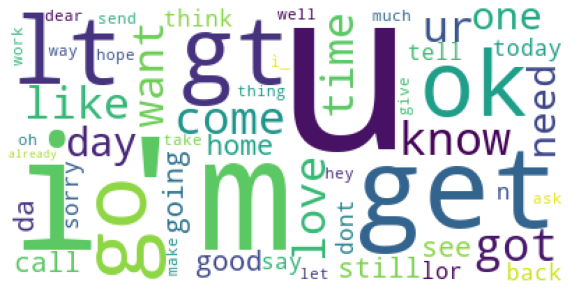

There are 695025 words in the combination of all HAM.


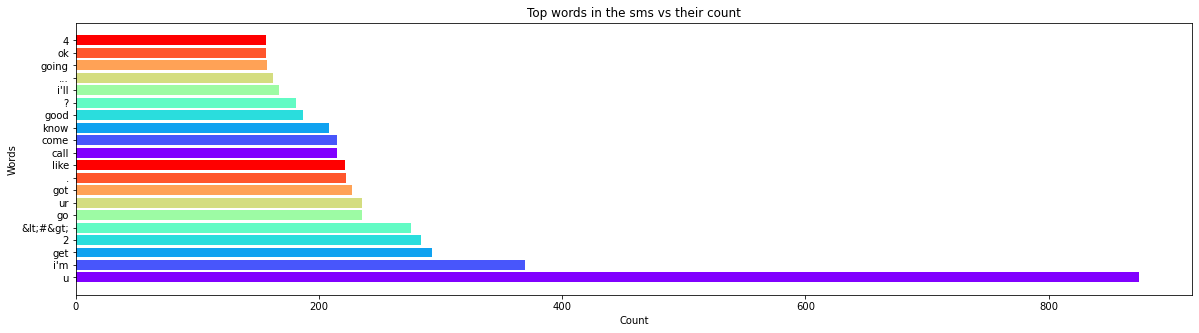

In [1325]:
#selection de la colonne ham et transformation en minuscule
ham = dfn['sms'].loc[dfn.label=='ham']
ham1 = ' '.join(ham.str.lower()) 

#----------------------------------------------------------------------------------------------------
#definition des stopword
stopwords = stopwords.words('english') #STOPWORDS
#stopwords.add('will')

wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=50).generate(ham1)
rcParams['figure.figsize'] = 10, 10
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#------------------------------------------------------------------------------------------------------
#We can even verify the top words using the bar charts.
filtered_words = [word for word in ham1.split() if word not in stopwords]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(20):
    words.append(letter)
    counts.append(count)
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 5


plt.title('Top words in the sms vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)
#-----------------------------------------------------
text = " ".join(review for review in ham1)
print ("There are {} words in the combination of all HAM.".format(len(text)))

Sur le graphique du dessus nous pouvons voir que les mots les plus communs dans les hams sont:

    -u
    -i'm
    -get
    -go
    -ur
    -got

#### Visualisation des mots dans les spams

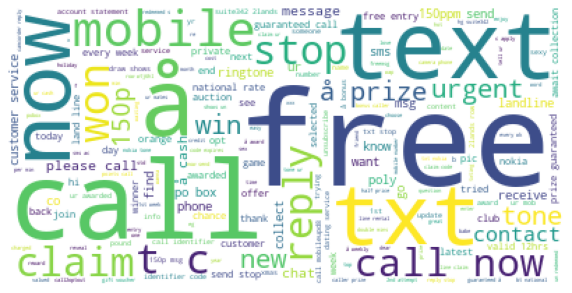

There are 208957 words in the combination of all SPAM.


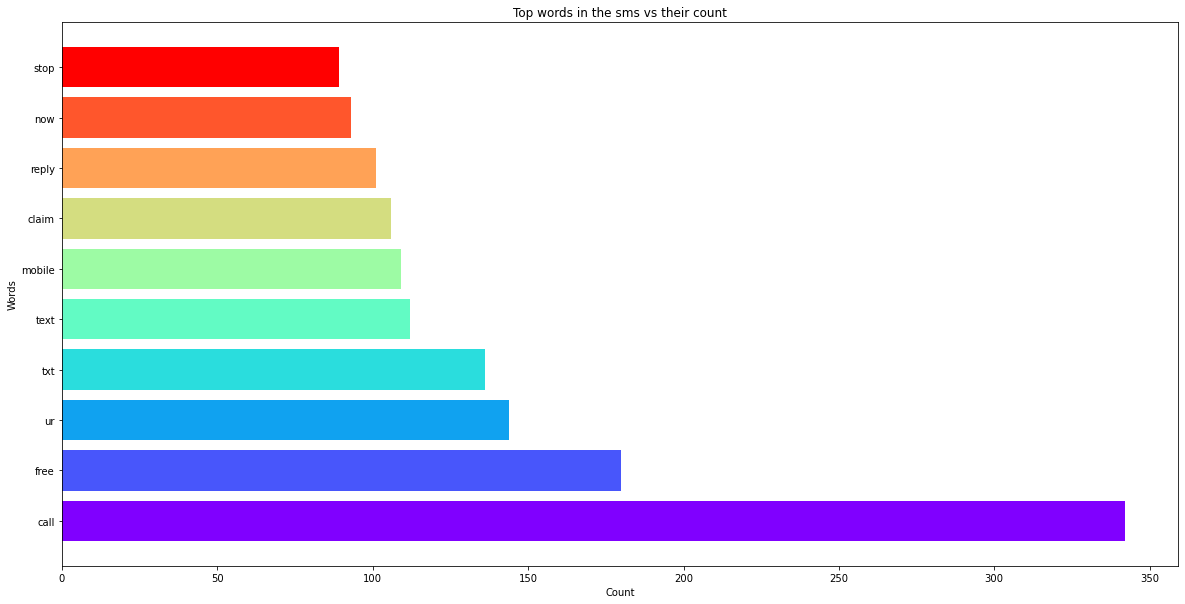

In [1326]:
from string import digits
#selection de la colonne ham et transformation en minuscule
spam = dfn['sms'].loc[dfn.label=='spam']
#spam0 = #filter(lambda x: x.isalpha(), spam) #spam.translate(None, digits)#''.join([i for i in spam if not i.isdigit()]) #str(spam)' '.join(spam.str.lower())
spam1 = ' '.join(spam.str.lower())
#----------------------------------------------------------------------------------------------------
#definition des stopword
stopwords = STOPWORDS
stopwords.add('co uk')
stopwords.add('u')
stopwords.add('will')
stopwords.add('-')
stopwords.add('&')
stopwords.add('2')
stopwords.add('4')
stopwords.add('')
stopwords.add('p')
stopwords.add('m')
stopwords.add('w')

wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(spam1)
rcParams['figure.figsize'] = 10, 10
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#------------------------------------------------------------------------------------------------------
#We can even verify the top words using the bar charts.
#creation de la boucle
filtered_words = [word for word in spam1.split() if word not in stopwords]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)

#creation du graph    
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10


plt.title('Top words in the sms vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)
#-----------------------------------------------------
text = " ".join(review for review in spam1)
print ("There are {} words in the combination of all SPAM.".format(len(text)))

sur le graphique du dessus nous pouvons voir que les mots les plus communs dans les spams sont:

    -call
    -free
    -ur
    -txt, text
    -mobile
    -claim

#### Creation d'un dictionnaire

Maintenant que nous avons analyser les mots les plus courants nous allons créer un dictionnaire:

In [1327]:
#filtre des mots
def create_dictionary(text):
    filtered_words = [word for word in re.split('[!?123456*-_+=;:7890/.,$% ]',text) if word not in stopwords]
    counted_words = collections.Counter(filtered_words)

    words = []
    counts = []
    #counte les mots les plus communs
    for letter, count in counted_words.most_common(50):
        words.append(letter)
        counts.append(count)
    return words

In [1328]:
dico = create_dictionary(spam1)
print('Voici les mots choisis pour le dico:',dico)

Voici les mots choisis pour le dico: ['call', 'å£', 'free', 'now', 'txt', 'ur', 'mobile', 'text', 'stop', 'claim', 'reply', 'prize', 'cash', 'won', 'win', 'nokia', 'send', 'new', 'urgent', 'tone', 'box', 'week', 'msg', 'service', 'contact', 'please', 'co', 'guaranteed', 'customer', 'ppm', 'per', 'mins', 'phone', 'chat', 'pobox', 'draw', 'awarded', 'min', 'latest', 'camera', 'line', 'message', 'sms', 'receive', 'go', 'find', 'every', 'holiday', 'landline', 'video']


#### COMPTAGE des mots spam dans les sms

Il nous manque plus qu'à les compter dans tous nos messages grace a une boucle qui pas vérifier la présence des mots de notre dico.

In [1329]:
def count_words(txt):
    count = 0
    txt = txt.lower()    
    txt = re.split('[!?123456*-_+=;:7890/.,$% ]',txt) #methode pour split la chaine de caractere pour pouvoir compter les mots
    #print(txt)
    word = dico
    for i in range(0,len(txt)):             
        #Checks whether given character is a punctuation mark      
        if txt[i] in (word):            
            count = count + 1;    
    return count 
dfn["spam_word"]=dfn.sms.apply(count_words)
#count_words('CALL! call? me now free')

In [1330]:
dfn

,label,sms,length,spam_word
0,ham,"Go until jurong point, crazy.. Available only ...",111,1
1,ham,Ok lar... Joking wif u oni...,29,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,5
3,ham,U dun say so early hor... U c already then say...,49,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,8
5568,ham,Will Ì_ b going to esplanade fr home?,37,0
5569,ham,"Pity, * was in mood for that. So...any other s...",57,0
5570,ham,The guy did some bitching but I acted like i'd...,125,2


In [1331]:
print(dico)

['call', 'å£', 'free', 'now', 'txt', 'ur', 'mobile', 'text', 'stop', 'claim', 'reply', 'prize', 'cash', 'won', 'win', 'nokia', 'send', 'new', 'urgent', 'tone', 'box', 'week', 'msg', 'service', 'contact', 'please', 'co', 'guaranteed', 'customer', 'ppm', 'per', 'mins', 'phone', 'chat', 'pobox', 'draw', 'awarded', 'min', 'latest', 'camera', 'line', 'message', 'sms', 'receive', 'go', 'find', 'every', 'holiday', 'landline', 'video']


In [1332]:
#dfn.sms.tolist()
#dfn.sms.str.lower()
#dfn

#### TOP HAM & SPAM 

In [1333]:
#visualisation des spam words dans les hams
dfnW = dfn.loc[dfn.label=='ham']
dfnW.sort_values(by=['spam_word'],ascending=False).head(10) #classer par ordre descendant


,label,sms,length,spam_word
4554,ham,7 wonders in My WORLD 7th You 6th Ur style 5th...,153,7
2980,ham,7 wonders in My WORLD 7th You 6th Ur style 5th...,153,7
1352,ham,Let Ur Heart Be Ur Compass Ur Mind Ur Map Ur S...,121,7
1778,ham,7 wonders in My WORLD 7th You 6th Ur style 5th...,153,7
1469,ham,7 wonders in My WORLD 7th You 6th Ur style 5th...,153,7
1363,ham,"Yetunde, i'm sorry but moji and i seem too bus...",207,6
1496,ham,I'm always on yahoo messenger now. Just send t...,158,6
2378,ham,"Hi, Mobile no. &lt;#&gt; has added you in th...",158,5
4771,ham,"Hi, Mobile no. &lt;#&gt; has added you in th...",158,5
2011,ham,Do whatever you want. You know what the rules ...,375,5


In [1334]:
#visualisation des spam words dans les spams
dfnW1 = dfn.loc[dfn.label=='spam']
dfnW1.sort_values(by=['spam_word'],ascending=False).head(10) #classer par ordre descendant


,label,sms,length,spam_word
5141,spam,FREE for 1st week! No1 Nokia tone 4 ur mobile ...,162,14
802,spam,FREE for 1st week! No1 Nokia tone 4 ur mobile ...,162,14
1016,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,158,13
3761,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,158,13
2663,spam,8007 FREE for 1st week! No1 Nokia tone 4 ur mo...,165,13
672,spam,Get ur 1st RINGTONE FREE NOW! Reply to this ms...,154,13
4196,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,158,13
2159,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,147,12
1220,spam,No. 1 Nokia Tone 4 ur mob every week! Just txt...,143,12
1379,spam,No. 1 Nokia Tone 4 ur mob every week! Just txt...,143,12


### Feature3: Recherche des URLs

Dans cette partie nous allons compter le nombre d'URL grace aux REGEX

##### Creation fonction find URL 

In [1335]:
#url_list = re.findall(r'(https?://\S+)', txt)
def get_url(txt):
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex,txt)
    return  [x[0] for x in url] 
def count_url(txt):
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex,txt)
    return  len([x[0] for x in url])

In [1336]:
#webbrowser.open('https://fr.acervolima.com/python-rechercher-une-url-dans-une-chaine/')

##### affichage url dans spam

In [1337]:
#affichage url dans spam
import re 
l = get_url(spam1) 
print(f"url={l}")
count_url(spam1)

url=['www.dbuk.net', 'http://wap', 'www.sms.ac/u/bootydelious', 'www.areyouunique.co.uk', 'www.4-tc.biz', 'www.ldew.com1win150ppmx3age16', 'www.100percent-real.com', 'http://img', 'www.ldew.com1win150ppmx3age16', 'www.regalportfolio.co.uk', 'www.txttowin.co.uk', 'www.07781482378.com', 'http://www.bubbletext.com', 'www.applausestore.com', 'www.txt-2-shop.com', 'http://www.e-tlp.co.uk/expressoffer', 'www.cnupdates.com/newsletter', 'www.getzed.co.uk', 'www.ldew.com1win150ppmx3age16', 'www.comuk.net', 'http://www.e-tlp.co.uk/expressoffer', 'www.smsco.net', 'http://doit', 'www.getzed.co.uk', 'www.flirtparty.us', 'http://www.urawinner.com', 'www.txt43.com', 'lucozade.co.uk/wrc', 'www.ldew.com.subs16+1win150ppmx3', 'www.phb1.com', 'www.textcomp.com', 'www.ringtones.co.uk', 'www.4-tc.biz', 'http://www.urawinner.com', 'www.ldew.com', 'www.textpod.net', 'www.80488.biz', 'www.orange.co.uk/ow', 'www.ringtoneking.co.uk', 'www.getzed.co.uk', 'www.movietrivia.tv', 'o2.co.uk/games', 'www.win-82050.co.

113

Il y a 113 url dans les spams 

##### affichage url dans ham

In [1338]:
#affichage url dans ham
l2 = get_url(ham1)
print(f"url={l2}")
print('Il y a',len(l2),'url dans les spams')

url=['www.fullonsms.com', 'staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323', 'www.fullonsms.com']
Il y a 3 url dans les spams


Nous remarquons qu'il a bien plus d'URL dans les spams que dans les hams

##### Rajout du nombre d'url dans DF

In [1339]:
#Rajout du nombre d'url dans DF
dfn["amount_url"]=dfn.sms.apply(count_url)
dfn

,label,sms,length,spam_word,amount_url
0,ham,"Go until jurong point, crazy.. Available only ...",111,1,0
1,ham,Ok lar... Joking wif u oni...,29,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,5,0
3,ham,U dun say so early hor... U c already then say...,49,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0,0
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,8,0
5568,ham,Will Ì_ b going to esplanade fr home?,37,0,0
5569,ham,"Pity, * was in mood for that. So...any other s...",57,0,0
5570,ham,The guy did some bitching but I acted like i'd...,125,2,0


##### Analyse du resultat dans les spams

In [1340]:
spamU = dfn.loc[dfn.label=='spam']
spamU.sort_values(by=['amount_url'],ascending=False).head(10) #classer par ordre descendant

,label,sms,length,spam_word,amount_url
3860,spam,Free Msg: Ringtone!From: http://tms. widelive....,109,2,2
1406,spam,"URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD...",163,2,1
3640,spam,You can stop further club tones by replying \S...,128,4,1
2307,spam,WIN a year supply of CDs 4 a store of ur choic...,147,7,1
832,spam,"Dear Voucher Holder, To claim this weeks offer...",152,7,1
4752,spam,Cashbin.co.uk (Get lots of cash this weekend!)...,155,4,1
865,spam,Congratulations ur awarded either a yrs supply...,161,6,1
4733,spam,Buy Space Invaders 4 a chance 2 win orig Arcad...,154,2,1
2266,spam,<Forwarded from 88877>FREE entry into our å£25...,122,4,1
4699,spam,WIN: We have a winner! Mr. T. Foley won an iPo...,132,6,1


### Feature4: Recherche des numeros de telephone

Dans cette partie nous allons rechercher les numéros de téléphones dans les sms

In [1341]:
def get_number10(txt):
    #number_list1 = re.findall(r"\D(\d{5})\D", txt)
    number_list2 =  re.findall("(?<!\d)\d{11}(?!\d)", txt)
    number_list3 =  re.findall("(?<!\d)\d{10}(?!\d)", txt)
    return  number_list2 + number_list3 
def len_number10(txt):
    #number_list1 = re.findall(r"\D(\d{5})\D", txt)
    number_list2 =  re.findall("(?<!\d)\d{11}(?!\d)", txt)
    number_list3 =  re.findall("(?<!\d)\d{10}(?!\d)", txt)
    return len( number_list2 + number_list3) 
    

In [1342]:
def get_number5(txt):
    number_list1 = re.findall(r"\D(\d{5})\D", txt)
    #number_list2 =  re.findall("(?<!\d)\d{11}(?!\d)", txt)
    #number_list3 =  re.findall("(?<!\d)\d{10}(?!\d)", txt)
    return number_list1  
def len_number5(txt):
    number_list1 = re.findall(r"\D(\d{5})\D", txt)
    #number_list2 =  re.findall("(?<!\d)\d{11}(?!\d)", txt)
    #number_list3 =  re.findall("(?<!\d)\d{10}(?!\d)", txt)
    return len(number_list1)  

Nous avons pu constater qu'il y a des numéros à 11, 10 et 5 digits dans les spams. De plus les numéro a 5 digits sont plutôt nombreux. En faisant une recherche nous avons trouvé que les numéros à 5 digits étaient des numéros payants.

In [1343]:
dfn['phone_number10'] = dfn.sms.apply(len_number10)
dfn['phone_number5'] = dfn.sms.apply(len_number5)

In [1344]:
dfn

,label,sms,length,spam_word,amount_url,phone_number10,phone_number5
0,ham,"Go until jurong point, crazy.. Available only ...",111,1,0,0,0
1,ham,Ok lar... Joking wif u oni...,29,0,0,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,5,0,1,1
3,ham,U dun say so early hor... U c already then say...,49,0,0,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0,0,0,0
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,8,0,0,0
5568,ham,Will Ì_ b going to esplanade fr home?,37,0,0,0,0
5569,ham,"Pity, * was in mood for that. So...any other s...",57,0,0,0,0
5570,ham,The guy did some bitching but I acted like i'd...,125,2,0,0,0


In [1345]:
#dfn.sms.tolist()

In [1346]:
#nombre de numero dans tous mes spams
l3 = get_number5(spam1)
l2 = get_number10(spam1)
#print(f"number={l2}")
print('Il y a',len(l2),'numeros de 10 et 11 digits dans les spams')
print('Il y a',len(l3),'numeros de 5 digits dans les spams')

Il y a 401 numeros de 10 et 11 digits dans les spams
Il y a 279 numeros de 5 digits dans les spams


In [1347]:
##nombre de numero dans tous mes hams
l4 = get_number10(ham1)
l5 = get_number5(ham1)
print(f"number={l4}")
print(f"number={l5}")
print('Il y a',len(l4),'numeros de 10 et 11 digits dans les spams')
print('Il y a',len(l5),'numeros de 5 digits dans les spams')

number=['0125698789']
number=[]
Il y a 1 numeros de 10 et 11 digits dans les spams
Il y a 0 numeros de 5 digits dans les spams


In [1348]:
spam.head(2)

2    Free entry in 2 a wkly comp to win FA Cup fina...
5    FreeMsg Hey there darling it's been 3 week's n...
Name: sms, dtype: object

Il y a beaucoup plus de numéro dans les spams que dans les hams. Cela confirme l'importance de cette feature dans notre DF.

### Feature5: Les majuscules

#### Nombre majuscule et minuscule dans tout le DF

Dans cette partie nous allons compter le nombre de majuscule et minuscule dans les sms. Nous avons fait une étude séparée sur les spams et les hams.

In [1349]:
v = dfn.sms.values.astype(str)
v = v.view(np.uint8).reshape(len(dfn), -1)

dfn['Uppercase'] = ((v >= 65) & (v <= 90)).sum(1)
dfn['Lowercase'] = ((v >= 97) & (v <= 122)).sum(1)
dfn

,label,sms,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase
0,ham,"Go until jurong point, crazy.. Available only ...",111,1,0,0,0,3,80
1,ham,Ok lar... Joking wif u oni...,29,0,0,0,0,2,16
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,5,0,1,1,10,87
3,ham,U dun say so early hor... U c already then say...,49,0,0,0,0,2,31
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0,0,0,0,2,45
...,...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,8,0,0,0,9,92
5568,ham,Will Ì_ b going to esplanade fr home?,37,0,0,0,0,1,26
5569,ham,"Pity, * was in mood for that. So...any other s...",57,0,0,0,0,2,39
5570,ham,The guy did some bitching but I acted like i'd...,125,2,0,0,0,2,97


#### Nombre majuscule et minuscule dans les spams

In [1350]:
spamUL = dfn.loc[dfn.label=='spam']
spamUL

,label,sms,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,5,0,1,1,10,87
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148,3,0,0,0,7,96
8,spam,WINNER!! As a valued network customer you have...,158,6,0,1,0,12,94
9,spam,Had your mobile 11 months or more? U R entitle...,154,8,0,1,0,14,97
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136,5,0,0,1,17,64
...,...,...,...,...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,90,3,0,1,0,17,34
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,160,5,0,0,0,104,1
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,160,7,0,0,0,20,103
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,147,4,0,0,0,14,98


In [1351]:
#dfn.sms.tolist()

In [1352]:
#-----------------------------------------------------------
print('Nombre de majuscule et minuscule')
hamUL_mean = spamUL[["Uppercase", "Lowercase"]].mean()
print(hamUL_mean)
#-----------------------------------------------------------
print('\nmoyenne majuscule')
spamUL_mean = spamUL[["Uppercase"]].mean()
print(spamUL_mean)
#----------------------------------------------------------
print('\nmoyenne longueur')
lenghtUL_mean = spamUL[["length"]].mean()
print(lenghtUL_mean)
#-----------------------------------------------------------
#calcul proportion
lg =lenghtUL_mean
u = spamUL_mean
results = (int(u)*100)/int(lg)
print('')
print('La proportion moyenne de majuscule dans les spams:', int(results))

Nombre de majuscule et minuscule
Uppercase    15.428380
Lowercase    78.178046
dtype: float64

moyenne majuscule
Uppercase    15.42838
dtype: float64

moyenne longueur
length    138.866131
dtype: float64

La proportion moyenne de majuscule dans les spams: 10


#### Nombre majuscule et minuscule dans les hams

In [1353]:
hamUL = dfn.loc[dfn.label=='ham']
hamUL

,label,sms,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase
0,ham,"Go until jurong point, crazy.. Available only ...",111,1,0,0,0,3,80
1,ham,Ok lar... Joking wif u oni...,29,0,0,0,0,2,16
3,ham,U dun say so early hor... U c already then say...,49,0,0,0,0,2,31
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0,0,0,0,2,45
6,ham,Even my brother is not like to speak with me. ...,77,0,0,0,0,2,58
...,...,...,...,...,...,...,...,...,...
5565,ham,Huh y lei...,12,0,0,0,0,1,6
5568,ham,Will Ì_ b going to esplanade fr home?,37,0,0,0,0,1,26
5569,ham,"Pity, * was in mood for that. So...any other s...",57,0,0,0,0,2,39
5570,ham,The guy did some bitching but I acted like i'd...,125,2,0,0,0,2,97


In [1354]:
hamUL_mean = hamUL[["Uppercase", "Lowercase"]].mean()
hamUL_mean

Uppercase     3.961036
Lowercase    49.355233
dtype: float64

In [1355]:
#-------------------------------------------------------
print('Nombre majuscule et minuscule')
hamUL_mean = hamUL[["Uppercase", "Lowercase"]].mean()
print(hamUL_mean)
#calcul moyenne majuscule
print('\nmoyenne majuscule')
hamUL_mean = hamUL[["Uppercase"]].mean()
print(hamUL_mean)
#-------------------------------------------------------
#calcul moyen d'un message
print('\nmoyenne longueur')
lenghtHUL_mean = hamUL[["length"]].mean()
print(lenghtHUL_mean)
#---------------------------------------------------------
#Calcul de la proportion de majuscule dans un message
lg1 =lenghtHUL_mean
u1 = hamUL_mean
results = (int(u1)*100)/int(lg1)
print('La proportion moyenne de majuscule:', int(results))

Nombre majuscule et minuscule
Uppercase     3.961036
Lowercase    49.355233
dtype: float64

moyenne majuscule
Uppercase    3.961036
dtype: float64

moyenne longueur
length    71.023627
dtype: float64
La proportion moyenne de majuscule: 4


On remarque que la proportion moyenne de majuscule est plus élevée dans les spams. Cela confirme l'intéret de notre feature dans le dataframe. 

### Feature6: Les caractères speciaux.

Dans cette partie nous allons compter le nombre de caractères speciaux dans les sms. Pour cela on Utilise une petite boucle qui va chercher une liste de caractère dans tous les sms.

In [1356]:
import numpy as np

def count_special_char(str):
    count = 0
    for i in range (0, len (str)):   
     #Checks whether given character is a punctuation mark  
        if str[i] in ('!' ,"\'" ,"\"","-" ,"$", "£","?","#", "%","_","*","=", "&", "'", ":","+"):  
            count = count + 1;  
            #print(count)
    return count
#print (count); 
dfn["special_char"]=dfn.sms.apply(count_special_char)
#dfn
#str = "Good Morning! Mr. James Potter. Had your breakfast?"


In [1357]:
dfn

,label,sms,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase,special_char
0,ham,"Go until jurong point, crazy.. Available only ...",111,1,0,0,0,3,80,0
1,ham,Ok lar... Joking wif u oni...,29,0,0,0,0,2,16,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,5,0,1,1,10,87,3
3,ham,U dun say so early hor... U c already then say...,49,0,0,0,0,2,31,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0,0,0,0,2,45,1
...,...,...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,8,0,0,0,9,92,4
5568,ham,Will Ì_ b going to esplanade fr home?,37,0,0,0,0,1,26,2
5569,ham,"Pity, * was in mood for that. So...any other s...",57,0,0,0,0,2,39,2
5570,ham,The guy did some bitching but I acted like i'd...,125,2,0,0,0,2,97,1


In [1358]:
spamSC = dfn.loc[dfn.label=='spam']
spamSC

,label,sms,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase,special_char
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,5,0,1,1,10,87,3
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148,3,0,0,0,7,96,7
8,spam,WINNER!! As a valued network customer you have...,158,6,0,1,0,12,94,4
9,spam,Had your mobile 11 months or more? U R entitle...,154,8,0,1,0,14,97,2
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136,5,0,0,1,17,64,2
...,...,...,...,...,...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,90,3,0,1,0,17,34,2
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,160,5,0,0,0,104,1,2
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,160,7,0,0,0,20,103,3
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,147,4,0,0,0,14,98,1


In [1359]:
#-------------------------------------------------------
print('Nombre moyen')
spamSC_mean = spamSC[["special_char"]].mean()
print(spamSC_mean)
#-------------------------------------------------------
#calcul moyen d'un message
print('\nmoyenne longueur')
lenghtSC_mean = spamUL[["length"]].mean()
print(lenghtSC_mean)
#---------------------------------------------------------
#Calcul de la proportion de majuscule dans un message
lg2 =lenghtSC_mean
u2 = spamSC_mean
results = (int(u2)*100)/int(lg2)
print('La proportion moyenne de caractère:', int(results),'%')

Nombre moyen
special_char    2.737617
dtype: float64

moyenne longueur
length    138.866131
dtype: float64
La proportion moyenne de caractère: 1 %


In [1360]:
hamSC = dfn.loc[dfn.label=='ham']
hamSC

,label,sms,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase,special_char
0,ham,"Go until jurong point, crazy.. Available only ...",111,1,0,0,0,3,80,0
1,ham,Ok lar... Joking wif u oni...,29,0,0,0,0,2,16,0
3,ham,U dun say so early hor... U c already then say...,49,0,0,0,0,2,31,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0,0,0,0,2,45,1
6,ham,Even my brother is not like to speak with me. ...,77,0,0,0,0,2,58,0
...,...,...,...,...,...,...,...,...,...,...
5565,ham,Huh y lei...,12,0,0,0,0,1,6,0
5568,ham,Will Ì_ b going to esplanade fr home?,37,0,0,0,0,1,26,2
5569,ham,"Pity, * was in mood for that. So...any other s...",57,0,0,0,0,2,39,2
5570,ham,The guy did some bitching but I acted like i'd...,125,2,0,0,0,2,97,1


In [1361]:
#-------------------------------------------------------
print('Nombre moyen')
hamSC_mean = hamSC[["special_char"]].mean()
print(hamSC_mean)
#-------------------------------------------------------
#calcul moyen d'un message
print('\nmoyenne longueur')
lenghtSC1_mean = hamSC[["length"]].mean()
print(lenghtSC1_mean)
#---------------------------------------------------------
#Calcul de la proportion de majuscule dans un message
lg3 =lenghtSC1_mean
u3 = hamSC_mean
results = (int(u3)*100)/int(lg3)
print('La proportion moyenne de majuscule:', int(results))

Nombre moyen
special_char    1.355026
dtype: float64

moyenne longueur
length    71.023627
dtype: float64
La proportion moyenne de majuscule: 1


En moyenne il y a plus de caractere speciaux dans les spams, cela comfirme aussi l'utilité de cette feature dans notre dataframe.

### Feature7: Longueur moyenne des mots

Enfin dans la dernière partie de la recherche des features nous avons calculé la longueur moyenne des spams

In [1362]:
import re
def lengh_word_mean(word):
    words = word.split()
    average = sum(len(word) for word in words) / len(words)
    return average
dfn["avg_word_len"]=dfn.sms.apply(lengh_word_mean)
dfn


,label,sms,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase,special_char,avg_word_len
0,ham,"Go until jurong point, crazy.. Available only ...",111,1,0,0,0,3,80,0,4.600000
1,ham,Ok lar... Joking wif u oni...,29,0,0,0,0,2,16,0,4.000000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,5,0,1,1,10,87,3,4.571429
3,ham,U dun say so early hor... U c already then say...,49,0,0,0,0,2,31,0,3.545455
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0,0,0,0,2,45,1,3.769231
...,...,...,...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,8,0,0,0,9,92,4,4.400000
5568,ham,Will Ì_ b going to esplanade fr home?,37,0,0,0,0,1,26,2,3.750000
5569,ham,"Pity, * was in mood for that. So...any other s...",57,0,0,0,0,2,39,2,4.800000
5570,ham,The guy did some bitching but I acted like i'd...,125,2,0,0,0,2,97,1,3.846154


In [1363]:
hamWM = dfn.loc[dfn.label=='ham']
hamWM

,label,sms,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase,special_char,avg_word_len
0,ham,"Go until jurong point, crazy.. Available only ...",111,1,0,0,0,3,80,0,4.600000
1,ham,Ok lar... Joking wif u oni...,29,0,0,0,0,2,16,0,4.000000
3,ham,U dun say so early hor... U c already then say...,49,0,0,0,0,2,31,0,3.545455
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0,0,0,0,2,45,1,3.769231
6,ham,Even my brother is not like to speak with me. ...,77,0,0,0,0,2,58,0,3.875000
...,...,...,...,...,...,...,...,...,...,...,...
5565,ham,Huh y lei...,12,0,0,0,0,1,6,0,3.333333
5568,ham,Will Ì_ b going to esplanade fr home?,37,0,0,0,0,1,26,2,3.750000
5569,ham,"Pity, * was in mood for that. So...any other s...",57,0,0,0,0,2,39,2,4.800000
5570,ham,The guy did some bitching but I acted like i'd...,125,2,0,0,0,2,97,1,3.846154


In [1364]:
print("La longueur moyenne d'un mot dans un ham:", hamWM.avg_word_len.mean())

La longueur moyenne d'un mot dans un ham: 4.177573771250962


In [1365]:
spamWM = dfn.loc[dfn.label=='spam']
spamWM 

,label,sms,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase,special_char,avg_word_len
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,5,0,1,1,10,87,3,4.571429
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148,3,0,0,0,7,96,7,3.656250
8,spam,WINNER!! As a valued network customer you have...,158,6,0,1,0,12,94,4,5.115385
9,spam,Had your mobile 11 months or more? U R entitle...,154,8,0,1,0,14,97,2,4.344828
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136,5,0,0,1,17,64,2,4.269231
...,...,...,...,...,...,...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,90,3,0,1,0,17,34,2,4.687500
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,160,5,0,0,0,104,1,2,3.878788
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,160,7,0,0,0,20,103,3,4.750000
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,147,4,0,0,0,14,98,1,4.285714


In [1366]:
print("La longueur moyenne d'un mot dans un spam:",spamWM.avg_word_len.mean())

La longueur moyenne d'un mot dans un spam: 4.992838622408249


Nous avons remarqué que les mots sont en moyenne plus long dans les spams.

## MACHINE LEARNING

Dans la 4 ième partie nous allons nous concentrer sur l'étude et le choix du modèle de ML. Nous commencerons par le modèle KNN et le modèle RF. Nous utiliserons aussi le GridSeach pour trouver les meilleurs hyperparamètre. et nous utiliserons aussi la méthode de cross validation car notre jeu de donnée est déséquilibré. 

### Visualisation des donnees dans le nouveau DF

Premierement nous analysons notre dataframe avec toutes les features pour verifier si tout est correct.

In [1367]:
#transform label en binaire
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder() 
dfn['label'] = lb.fit_transform(dfn['label'])
dfn

,label,sms,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase,special_char,avg_word_len
0,0,"Go until jurong point, crazy.. Available only ...",111,1,0,0,0,3,80,0,4.600000
1,0,Ok lar... Joking wif u oni...,29,0,0,0,0,2,16,0,4.000000
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,5,0,1,1,10,87,3,4.571429
3,0,U dun say so early hor... U c already then say...,49,0,0,0,0,2,31,0,3.545455
4,0,"Nah I don't think he goes to usf, he lives aro...",61,0,0,0,0,2,45,1,3.769231
...,...,...,...,...,...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,8,0,0,0,9,92,4,4.400000
5568,0,Will Ì_ b going to esplanade fr home?,37,0,0,0,0,1,26,2,3.750000
5569,0,"Pity, * was in mood for that. So...any other s...",57,0,0,0,0,2,39,2,4.800000
5570,0,The guy did some bitching but I acted like i'd...,125,2,0,0,0,2,97,1,3.846154


Ensuite nous utilisont la methode describe pour comprendre notre nouveau DF.

In [1368]:
#caracteristique des spams
spam = dfn.loc[dfn.label==1]
spam.describe()

,label,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase,special_char,avg_word_len
count,747.0,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,1.0,138.866131,5.266399,0.151272,0.536814,0.334672,15.428380,78.178046,2.737617,4.992839
std,0.0,29.183082,2.752524,0.362273,0.566890,0.528456,12.306787,22.029511,2.201807,1.005943
min,1.0,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.333333
25%,1.0,132.500000,3.000000,0.000000,0.000000,0.000000,7.000000,66.000000,1.000000,4.423077
50%,1.0,149.000000,5.000000,0.000000,1.000000,0.000000,13.000000,82.000000,2.000000,4.884615
75%,1.0,157.000000,7.000000,0.000000,1.000000,1.000000,21.000000,94.000000,4.000000,5.375000
max,1.0,224.000000,14.000000,2.000000,2.000000,3.000000,128.000000,137.000000,20.000000,17.333333


In [1369]:
#caracteristique des hams
ham = dfn.loc[dfn.label==0]
ham.describe() 


,label,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase,special_char,avg_word_len
count,4825.0,4825.000000,4825.000000,4825.000000,4825.000000,4825.0,4825.000000,4825.000000,4825.000000,4825.000000
mean,0.0,71.023627,0.433782,0.000622,0.000207,0.0,3.961036,49.355233,1.355026,4.177574
std,0.0,58.016023,0.776560,0.024930,0.014396,0.0,10.099676,41.652164,2.146811,1.133530
min,0.0,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.500000
25%,0.0,33.000000,0.000000,0.000000,0.000000,0.0,1.000000,23.000000,0.000000,3.600000
50%,0.0,52.000000,0.000000,0.000000,0.000000,0.0,2.000000,37.000000,1.000000,4.000000
75%,0.0,92.000000,1.000000,0.000000,0.000000,0.0,3.000000,65.000000,2.000000,4.500000
max,0.0,910.000000,7.000000,1.000000,1.000000,0.0,127.000000,706.000000,56.000000,49.000000


Nous analysons grace à la moyen les caracteriques moyennes des spams et des hams. Cela nous permet de bien remarquer la différence entre les deux type de message.

<AxesSubplot:>

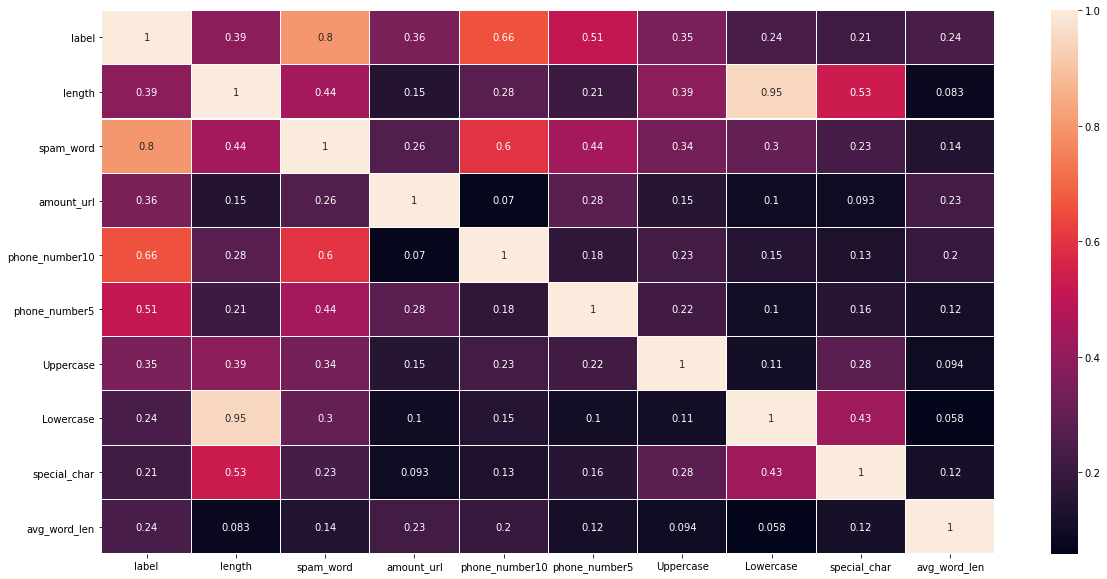

In [1370]:
# Plot heatmap with seaborn
import seaborn as sns
sns.heatmap(dfn.corr(), annot=True, linewidths=0.1)

La heatmap nous permet de voir si il y a des corrélations entre les différentes features et le label.
Nous remarquons très vite que les numéros de téléphone influe beaucoup sur le label (spam et ham)

In [1371]:
#sns.pairplot(dfn)

In [1372]:
#creation d'une visualisation 3D
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
dfn.head()

,label,sms,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase,special_char,avg_word_len
0,0,"Go until jurong point, crazy.. Available only ...",111,1,0,0,0,3,80,0,4.600000
1,0,Ok lar... Joking wif u oni...,29,0,0,0,0,2,16,0,4.000000
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,5,0,1,1,10,87,3,4.571429
3,0,U dun say so early hor... U c already then say...,49,0,0,0,0,2,31,0,3.545455
4,0,"Nah I don't think he goes to usf, he lives aro...",61,0,0,0,0,2,45,1,3.769231


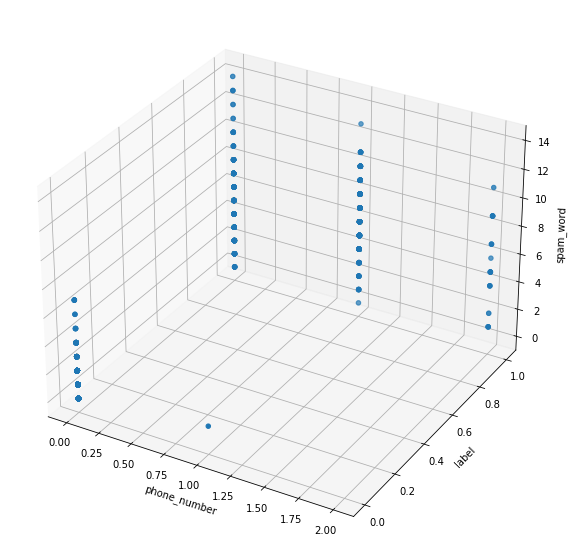

In [1373]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(dfn['phone_number10'], dfn['label'], dfn['spam_word'])
threedee.set_xlabel('phone_number')
threedee.set_ylabel('label')
threedee.set_zlabel('spam_word')
plt.show()

In [1374]:
dfn.head()

,label,sms,length,spam_word,amount_url,phone_number10,phone_number5,Uppercase,Lowercase,special_char,avg_word_len
0,0,"Go until jurong point, crazy.. Available only ...",111,1,0,0,0,3,80,0,4.600000
1,0,Ok lar... Joking wif u oni...,29,0,0,0,0,2,16,0,4.000000
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,5,0,1,1,10,87,3,4.571429
3,0,U dun say so early hor... U c already then say...,49,0,0,0,0,2,31,0,3.545455
4,0,"Nah I don't think he goes to usf, he lives aro...",61,0,0,0,0,2,45,1,3.769231


In [1375]:
#webbrowser.open('https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html')

### Entrainement du jeu de donnee et choix du model

Nous pouvons enfin entrainer notre jeu de donnée grace à la méthode train test split en utilisant le paramétre Stratify pour équilibré les spams et les hams dans la séparation des donnée.

In [1376]:
from sklearn.model_selection import train_test_split

In [1377]:
y = dfn['label']
X = dfn.drop(['label','sms'], axis = 1 )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=(y))
print('train set:', X_train.shape)
print('test set:', X_test.shape)

train set: (4457, 9)
test set: (1115, 9)


### Prediction avec KNN

On entraine notre premier modèle: KNN 

In [1378]:
from sklearn.neighbors import KNeighborsClassifier
modelKN = KNeighborsClassifier(n_neighbors=10)
modelKN.fit(X_train, y_train)
#print('train score:', modelKN.score(X_train,y_train))
#print('test score:', modelKN.score(X_test,y_test))


KNeighborsClassifier(n_neighbors=10)

On utilise la fonction cross validation pour remarquer si il y a des ecarts entre la performance du modèle et le résultat du SKF.

In [1379]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [1380]:
#cross validation 
cv = StratifiedKFold(10)
val_score = cross_val_score(modelKN, X_train, y_train, cv=cv)
print(val_score)
print('moyenne_train:',(val_score.mean())*100,'%')

[0.93946188 0.95964126 0.9573991  0.95964126 0.94843049 0.95515695
 0.95515695 0.96404494 0.95955056 0.95730337]
moyenne_train: 95.55786768781176 %


voici les resultats de notre modele

In [1381]:
modelKN.fit(X_train, y_train)
print('train score:', (modelKN.score(X_train,y_train))*100,'%')
print('test score:', (modelKN.score(X_test,y_test))*100,'%')

train score: 96.34283150100966 %
test score: 94.7085201793722 %


On remarque que la difference entre les resultats de la cross validation et les résultats de notre modèle ne sont pas très éloignés. 

#### Validation curve par une boucle

In [1382]:
#validation curve par une boucle
val_score = []
for k in range(1, 10):
    cv = StratifiedKFold(10)
    score = cross_val_score(KNeighborsClassifier(k), X_train, y_train, cv=cv).mean()
    val_score.append(score)
#plt.plot(val_score)


In [1383]:
#validation curve par la methode validation_curve
from sklearn.model_selection import validation_curve
model = KNeighborsClassifier()
k = np.arange(1, 15,2)
train_score,val_score1 = validation_curve(model, X_train, y_train,param_name='n_neighbors',param_range=k,cv=5)
val_score1.mean(axis=1)

array([0.95961332, 0.9593886 , 0.95669676, 0.95826803, 0.95624909,
       0.95378121, 0.95355599])

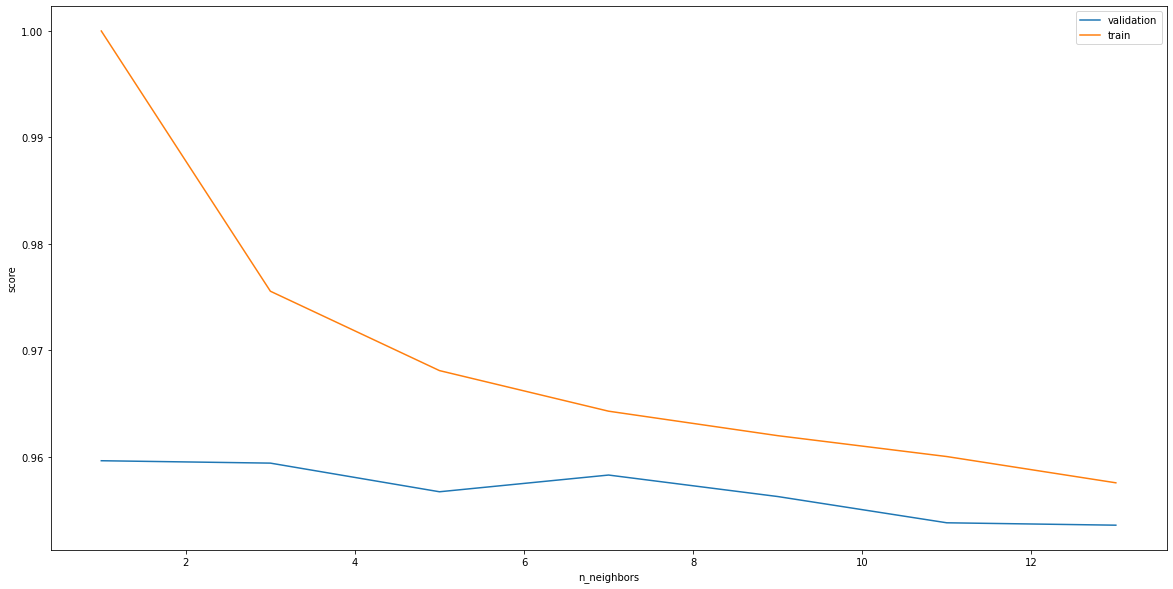

In [1384]:
plt.plot(k, val_score1.mean(axis=1),label = 'validation')
plt.plot(k, train_score.mean(axis=1), label="train")
plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

On est en overfiting quand k=1 dans le train

#### confusion matrix et metrics

In [1385]:
#confusion matrix
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, f1_score

prediction = modelKN.predict(X_train)
#print(prediction.tolist())
prediction2 = modelKN.predict(X_test)

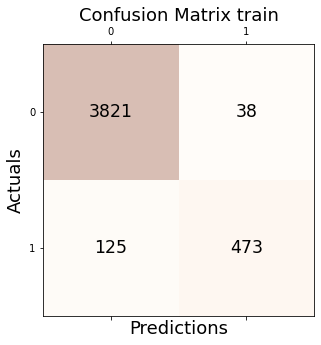

In [1386]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, prediction)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix train', fontsize=18)
plt.show()

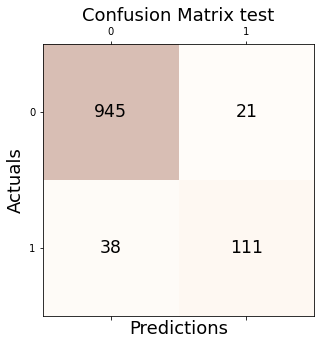

In [1387]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, prediction2)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix test', fontsize=18)
plt.show()

In [1388]:
#recall
print('recall',(recall_score(y_train, prediction,pos_label=1))*100,'%')
print('Accuracy: %.3f' % accuracy_score(y_test, prediction2))
print('F1 Score: %.3f' % f1_score(y_test, prediction2,pos_label=1))

recall 79.09698996655518 %
Accuracy: 0.947
F1 Score: 0.790


Nous constatons que le Recall est de 80%, cela signifie que 80% des spam sont bien identifier. Nous allons tester un nouveau modele pour essayer d'ameliorer les performance.

### Prediction avec Randomforest

Nous allons tester notre jeu de donnée avec le modèle Randomforest

In [1389]:
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier()
modelRF.fit(X_train, y_train)


RandomForestClassifier()

In [1390]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv1 = StratifiedKFold(5)
val_crossRF = cross_val_score(modelRF, X_train, y_train, cv=cv1)
print(val_crossRF)
print('score moyen:',(val_crossRF.mean())*100,'%')

[0.98878924 0.98542601 0.98204265 0.98765432 0.98540965]
score moyen: 98.58643736820119 %


In [1391]:
scoreRF = modelRF.score(X_test, y_test)
print(scoreRF*100,'%')

98.7443946188341 %


On remarque que la difference entre les resultats de la cross validation et les résultats de notre modèle ne sont pas très éloignés. 

In [1392]:
#confusion matrix
from sklearn.metrics import confusion_matrix, recall_score

predictionRF = modelRF.predict(X_train)
#print(prediction.tolist())
predictionRF_test = modelRF.predict(X_test)

In [1393]:
confusion_matrix(y_train, predictionRF)

array([[3859,    0],
       [   0,  598]], dtype=int64)

In [1394]:
confusion_matrix(y_test, predictionRF_test)

array([[965,   1],
       [ 13, 136]], dtype=int64)

In [1395]:
#recall
print('bonne prediction des spam:',(recall_score(y_train, predictionRF))*100,'%')

bonne prediction des spam: 100.0 %


In [1396]:
#recall
print('bonne prediction des spam:',(recall_score(y_test, predictionRF_test))*100,'%')

bonne prediction des spam: 91.2751677852349 %


Conclusion:
Nous remarquons que le modèle RF est meilleur pour predire les spams. Nous allons choisir ce modèle pour notre client. Il a de meilleur performance, de plus notre client voudrait avoir un modèle plus performant pour predir les spams. Maintenant nous allons utiliser la méthode Gridseach pour trouver les meilleurs parametre pour notre modèle.

####  GridSearchCV

Dans cette partie nous allons utiliser le GridSearch pour trouver les meilleurs parametre

In [1397]:
from sklearn.model_selection import GridSearchCV

In [1398]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())


Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [1399]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [1400]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [1401]:
pprint(rf_random.best_params_)

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 2000}


In [1402]:
import plotly.graph_objects as go

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    #predictions.reshape(1115) # tres important!!!
    accuracy = model.score(test_features, test_labels)
    print('Model Performance')
    print('Accuracy =',accuracy*100,'%')
    #recall = recall_score(test_labels,predictions)
   # print(recall)
   
    return accuracy

Nous allons comparer ici la différence entre un modèle utilisant les hyperparametre de base avec 10 estimators et un modele utilisant un gridsearch.

In [1403]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Accuracy = 98.38565022421525 %


In [1404]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Accuracy = 98.7443946188341 %


In [1405]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.36%.


nous remarquons que le gridseach nous donne de meilleurs résulats

In [1406]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 15, 20],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)


In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_search.fit(X_train, y_train)
grid_accuracy = evaluate(best_grid, X_test, y_test)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [ ]:
rf.feature_importances_